In [50]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import matplotlib.pyplot as plt
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
import pandas as pd
from utils.visualise import visualize_layer_weights
from models.mnist_conv import mnist_conv
from models.aux_funs import net_sparsity
import pprint

import numpy as np

# Fix the random seed

In [51]:
random_seed = 2
cf.seed_torch(random_seed)

# Configure the expirement

In [52]:
# weights_path = '../ProbMask/runs/mnist_conv_fashion_mnist-pr0.1/probmask/prune_rate=0.9/checkpoints/epoch_29.state'
weights_path = '../checkpoints/mnist_conv_sparse_linbreg_ggmodel_lambda_4.pth'
sparse_weights_path = weights_path
dense_weights_path = '../checkpoints/mnist_conv_dense.pth'
conf_args = {#
    # data specification
    'data_file':"../../Data",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':0, 'cuda_device':0, 'pin_memory':True,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.07, 'lamda_0':0.4, 'lamda_1':0.4, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,1,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
    'batch_size': 1000
}

conf = cf.Conf(**conf_args)

# Initiate model

In [53]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs).to(conf.device)

# Load model weights

In [54]:
def remove_module_prefix(state_dict):
    new_state_dict = {}
    for key in state_dict.keys():
        new_key = key.replace('module.', '')  # Remove the 'module.' prefix
        new_state_dict[new_key] = state_dict[key]
    return new_state_dict


# Dataset

In [55]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# Show the model works

# Attack the Model

In [56]:
def bim_attack(model, data, target, eps, alpha, iters):
    # Copy the original images to avoid modifying them
    adv_images = data.clone().detach().requires_grad_(True)
    
    # Loop over the number of iterations
    for i in range(iters):
        # Requires gradient

        # Forward pass
        outputs = model(adv_images)

        model.zero_grad()

        # Calculate loss
        loss = F.cross_entropy(outputs, target)

        # Backward pass
        loss.backward()
        
        # Adversarial example update
        with torch.no_grad():
            grad = adv_images.grad
            if grad is None:
                print(f'grad is None at {i}')
                continue
                
            perturbation = alpha * grad.sign()
            adv_images = adv_images + perturbation
            perturbation = torch.clamp(adv_images - data, min=-eps, max=eps)
            adv_images = torch.clamp(data + perturbation, min=0, max=1)
            adv_images = adv_images.detach().requires_grad_(True)

    return adv_images.detach()
    

def get_batch(loader):
    for data, target in loader:
        return data, target
    
    
def test_bim(model, data, target, conf, epsilon, alpha):
    correct = 0
    adv_examples = []
    for x, y in zip(data, target):
        x, y = x.unsqueeze(0).to(conf.device), y.to(conf.device)
        output = model(x)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == y.item():
            correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = x.squeeze().detach().cpu().numpy()
                adv_examples.append( (y.item(), final_pred.item(), adv_ex) )
        
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(data)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(conf.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(conf.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def attack_fgsm(model, data, target, epsilon):
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True
    # Forward pass the data through the model
    output = model(data) 
    # Calculate the loss 
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()
    # Collect ``datagrad``
    data_grad = data.grad.data
    # Restore the data to its original scale
    data_denorm = denorm(data)
    # Call FGSM Attack
    perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
    # Reapply normalization
    perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

    # Return the accuracy and an adversarial example
    return perturbed_data_normalized

def test_fgm(model, test_loader, conf, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    x, y = get_batch(test_loader)
    for data, target in zip(x, y):

        # Send the data and label to the device
        data, target = data.unsqueeze(0).to(conf.device), target.unsqueeze(0).to(conf.device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue
            
        # Calculate the loss 
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


def load_model(conf, ppath):
    model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

    model = mnist_conv(**model_kwargs).to(conf.device)
    model_weights = torch.load(ppath, map_location=conf.device)

    model.load_state_dict(model_weights)

    return model


In [38]:
base_path = '../checkpoints' 

models = [('sparse 2%', 'redo_linbreg_2pc_lambda_4.pth'), 
          ('dense', 'mnist_conv_dense.pth' )]
alpha = .1
iters = 10

stats = { 'sparse 2%': [],  'dense': []}

eps_inc = 0.004
for (name, path) in models:
    print(f"Model {name}")
    model = load_model(conf, f'{base_path}/{path}')
    data, target = get_batch(test_loader)
        
    for img, targ in zip(data, target):
        eps = 0
        pred = targ.clone()
        while pred.item() == targ.item():
            eps += eps_inc
            img_clone = img.clone().unsqueeze(0).to(conf.device)
            targ = torch.tensor([targ]).to(conf.device)
            adv = bim_attack(model, img_clone, targ, eps, alpha, iters)
            output = model(adv)
            pred = output.max(1, keepdim=True)[1]
        print(pred.item(), targ.item(), eps)
        stats[name].append((targ.item(), pred.item(), eps))
    

Model sparse 2%
7 9 0.024
6 2 0.04000000000000001
7 1 0.060000000000000026
3 1 0.08400000000000005
4 6 0.032
7 1 0.06800000000000003
2 4 0.004
4 6 0.004
8 5 0.036000000000000004
5 7 0.032
2 4 0.016
8 5 0.08000000000000004
5 7 0.004
1 3 0.07200000000000004
6 4 0.060000000000000026
3 1 0.05200000000000002
6 2 0.028
2 4 0.004
4 8 0.07600000000000004
6 0 0.028
8 2 0.004
7 5 0.004
8 7 0.04000000000000001
5 9 0.004
3 1 0.07600000000000004
6 4 0.004
4 6 0.02
3 0 0.016
7 9 0.048000000000000015
4 3 0.004
6 8 0.09200000000000005
3 8 0.008
1 3 0.048000000000000015
6 3 0.008
6 8 0.032
6 0 0.008
5 7 0.028
8 5 0.05600000000000002
8 7 0.04400000000000001
7 9 0.036000000000000004
0 6 0.004
3 1 0.07600000000000004
6 3 0.004
9 7 0.004
4 6 0.004
9 7 0.016
6 2 0.008
3 1 0.032
6 2 0.02
6 2 0.004
2 4 0.004
2 4 0.004
7 5 0.07200000000000004
6 8 0.012
3 2 0.024
6 2 0.016
6 8 0.07200000000000004
2 4 0.004
4 8 0.08000000000000004
6 0 0.02
8 7 0.04400000000000001
9 7 0.024
7 8 0.07600000000000004
8 5 0.032
7 1 0

In [39]:
def get_average(predictions):
    eps = 0
    for pred in predictions:
        eps += pred[2]
    return eps / len(predictions)

def get_average_per_class(predictions):
    eps = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8:[], 9:[]}
    for pred in predictions:
        eps[pred[0]].append(pred[2])
    for key in eps.keys():
        eps[key] = sum(eps[key]) / len(eps[key])
    return eps
    

In [43]:
print("BIM STATS")
for stat in stats:
    print(f"Model {stat}")
    print(f"Average: {get_average(stats[stat])}")
    pprint.pprint(f"Average per class: {get_average_per_class(stats[stat])}")

BIM STATS
Model sparse 2%
Average: 0.03407599999999993
('Average per class: {0: 0.0200747663551402, 1: 0.056495238095238084, 2: '
 '0.01509909909909911, 3: 0.04090322580645164, 4: 0.02166956521739132, 5: '
 '0.04551724137931038, 6: 0.011051546391752584, 7: 0.030568421052631602, 8: '
 '0.05848421052631577, 9: 0.04770526315789476}')
Model dense
Average: 0.03989999999999992
('Average per class: {0: 0.024224299065420576, 1: 0.08266666666666665, 2: '
 '0.014126126126126137, 3: 0.04141935483870971, 4: 0.022573913043478278, 5: '
 '0.05333333333333334, 6: 0.015257731958762897, 7: 0.04197894736842109, 8: '
 '0.057557894736842106, 9: 0.053010526315789466}')


In [44]:
data_dict = stats
df = pd.DataFrame(data_dict)
df.head(5)

,sparse 2%,dense
0,"(9, 7, 0.024)","(9, 7, 0.04400000000000001)"
1,"(2, 6, 0.04000000000000001)","(2, 4, 0.036000000000000004)"
2,"(1, 7, 0.060000000000000026)","(1, 3, 0.12800000000000009)"
3,"(1, 3, 0.08400000000000005)","(1, 3, 0.11200000000000007)"
4,"(6, 4, 0.032)","(6, 0, 0.016)"


In [45]:
df.to_csv('../results/BIM_attack_epsilon_per_image.csv')

# FGM Attack

In [89]:
x, y = get_batch(test_loader)


(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [63]:
base_path = '../checkpoints' 

models = [('sparse 2%', 'redo_linbreg_2pc_lambda_4.pth'), 
          ('dense', 'mnist_conv_dense.pth' )]
alpha = .1
iters = 10

stats = { 'sparse 2%': [],  'dense': []}

eps_inc = 0.004
for (name, path) in models:
    print(f"Model {name}")
    model = load_model(conf, f'{base_path}/{path}')
    data, target = get_batch(test_loader)
        
    for img, targ in zip(data, target):
        eps = 0
        pred = targ.clone()
        while pred.item() == targ.item() and eps < 1:
            eps += eps_inc
            img_clone = img.clone().unsqueeze(0).to(conf.device)
            targ = torch.tensor([targ]).to(conf.device)
            adv = attack_fgsm(model, img_clone, targ, eps)
            output = model(adv)
            pred = output.max(1, keepdim=True)[1]
        print(pred.item(), targ.item(), eps)
        stats[name].append((targ.item(), pred.item(), -1 if eps >= 1 else eps))

Model sparse 2%
8 9 0.008
6 2 0.02
7 1 0.016
3 1 0.028
2 6 0.012
6 1 0.028
2 4 0.004
4 6 0.004
8 5 0.008
8 7 0.012
2 4 0.012
8 5 0.02
8 7 0.004
8 3 0.04000000000000001
6 4 0.02
3 1 0.012
5 2 0.028
2 4 0.004
4 8 0.024
6 0 0.012
8 2 0.004
7 5 0.004
8 7 0.008
5 9 0.004
3 1 0.024
6 4 0.004
4 6 0.008
3 0 0.004
8 9 0.016
4 3 0.004
2 8 0.036000000000000004
3 8 0.004
8 3 0.016
6 3 0.004
6 8 0.008
6 0 0.004
5 7 0.012
8 5 0.02
8 7 0.012
8 9 0.02
0 6 0.004
3 1 0.024
6 3 0.004
9 7 0.004
4 6 0.004
9 7 0.008
6 2 0.008
3 1 0.012
3 2 0.008
6 2 0.004
2 4 0.004
2 4 0.004
2 5 0.02
6 8 0.004
3 2 0.012
6 2 0.008
6 8 0.028
2 4 0.004
6 8 0.12000000000000008
6 0 0.008
8 7 0.012
8 7 0.008
6 8 0.05200000000000002
8 5 0.008
6 1 0.032
3 1 0.012
6 2 0.004
4 3 0.004
7 9 0.004
6 8 0.06800000000000003
8 7 0.012
3 0 0.012
3 2 0.028
4 6 0.012
4 2 0.004
8 3 0.008
3 1 0.028
6 2 0.016
6 8 0.032
6 4 0.008
6 1 0.02
6 8 0.04400000000000001
8 5 0.012
8 9 0.024
8 5 0.02
6 0 0.012
4 3 0.008
4 2 0.012
6 0 0.012
2 6 0.004
8 5 0.0

In [64]:
print("FGSM STATS")
for stat in stats:
    print(f"Model {stat}")
    print(f"Average: {get_average(stats[stat])}")
    pprint.pprint(f"Average per class: {get_average_per_class(stats[stat])}")

FGSM STATS
Model sparse 2%
Average: 0.012547999999999835
('Average per class: {0: 0.009682242990654212, 1: 0.018057142857142872, 2: '
 '0.008936936936936942, 3: 0.019139784946236575, 4: 0.013147826086956532, 5: '
 '0.012597701149425296, 6: -0.0036288659793814373, 7: 0.010484210526315797, 8: '
 '0.01890526315789476, 9: 0.01890526315789475}')
Model dense
Average: 0.016043999999999798
('Average per class: {0: 0.012672897196261692, 1: 0.037219047619047645, 2: '
 '0.007063063063063068, 3: 0.02713978494623658, 4: 0.009460869565217397, 5: '
 '0.01788505747126438, 6: 0.007422680412371139, 7: 0.014357894736842116, 8: '
 '0.0067368421052631765, 9: 0.022147368421052648}')


In [65]:
data_dict = stats
df = pd.DataFrame(data_dict)
df.head(5)

,sparse 2%,dense
0,"(9, 8, 0.008)","(9, 7, 0.016)"
1,"(2, 6, 0.02)","(2, 6, 0.016)"
2,"(1, 7, 0.016)","(1, 0, 0.05600000000000002)"
3,"(1, 3, 0.028)","(1, 0, 0.048000000000000015)"
4,"(6, 2, 0.012)","(6, 0, 0.008)"


In [66]:
df.to_csv('../results/FGSM_attack_epsilon_per_image.csv')

In [67]:
def exclude_non_classified(data):
    return [x for x in data if x[2] != -1]

In [70]:
for stat in stats:
    stats[stat] = exclude_non_classified(stats[stat])
    print(f"Model {stat}")
    print(f"Average: {get_average(stats[stat])}")
    pprint.pprint(f"Average per class: {get_average_per_class(stats[stat])}")

Model sparse 2%
Average: 0.01457715430861703
('Average per class: {0: 0.009682242990654212, 1: 0.018057142857142872, 2: '
 '0.008936936936936942, 3: 0.019139784946236575, 4: 0.013147826086956532, 5: '
 '0.012597701149425296, 6: 0.006750000000000005, 7: 0.010484210526315797, 8: '
 '0.02974468085106385, 9: 0.01890526315789475}')
Model dense
Average: 0.018080160320641133
('Average per class: {0: 0.012672897196261692, 1: 0.037219047619047645, 2: '
 '0.007063063063063068, 3: 0.02713978494623658, 4: 0.009460869565217397, 5: '
 '0.01788505747126438, 6: 0.007422680412371139, 7: 0.014357894736842116, 8: '
 '0.028387096774193567, 9: 0.022147368421052648}')


In [71]:
data_dict = stats
df = pd.DataFrame(data_dict)
df.head(5)

,sparse 2%,dense
0,"(9, 8, 0.008)","(9, 7, 0.016)"
1,"(2, 6, 0.02)","(2, 6, 0.016)"
2,"(1, 7, 0.016)","(1, 0, 0.05600000000000002)"
3,"(1, 3, 0.028)","(1, 0, 0.048000000000000015)"
4,"(6, 2, 0.012)","(6, 0, 0.008)"


In [73]:
df.to_csv('../results/FGSM_attack_epsilon_per_image_excluded.csv')

In [24]:
df.to_csv('../results/dense_multi_sparse_FGSM_attack.csv')

In [25]:
df = pd.read_csv('../results/dense_multi_sparse_FGSM_attack.csv')
df.set_index('eps', inplace=True)
df

,sparse 2%,sparse 5%,sparse 10%,sparse 20%,sparse 40%,dense
eps,,,,,,
0.000,85.2,87.2,86.6,88.8,90.0,90.7
0.004,75.8,72.7,70.1,73.1,74.5,75.7
0.008,67.3,60.4,54.1,59.0,60.8,60.8
0.012,58.4,48.1,43.0,47.0,47.1,47.4
0.016,51.3,38.3,36.2,36.9,36.2,36.8
0.020,45.9,27.7,29.8,28.5,28.3,27.2
0.024,40.1,20.1,24.6,22.7,22.2,19.9
0.028,36.7,14.8,21.5,18.2,17.0,15.7
0.032,33.4,11.1,18.0,14.4,13.0,12.8


TypeError: cannot unpack non-iterable int object

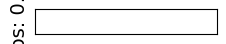

In [26]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(ex[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(ex[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()